In [ ]:
import os
import pandas as pd

path = "data/raw/"
files = [path + "common_player_info.csv", path + "draft_combine_stats.csv", path + "draft_combine_stats.csv", path + "draft_combine_stats.csv", path + "draft_history.csv", path + "game.csv", path + "game_info.csv", path + "game_summary.csv", path + "inactive_players.csv", path + "line_score.csv", path + "officials.csv", path + "other_stats.csv", path + "player.csv", path + "team.csv", path + "team_details.csv", path + "team_history.csv", path + "team_info_common.csv"]
table = {}
for file in files:
    filename = os.path.splitext(os.path.basename(file))[0] 
    table[filename] = pd.read_csv(file)

In [3]:
print(table['common_player_info'])

      person_id first_name     last_name   display_first_last  \
0         76001       Alaa     Abdelnaby       Alaa Abdelnaby   
1         76003     Kareem  Abdul-Jabbar  Kareem Abdul-Jabbar   
2          1505      Tariq   Abdul-Wahad    Tariq Abdul-Wahad   
3           949    Shareef   Abdur-Rahim  Shareef Abdur-Rahim   
4         76005        Tom     Abernethy        Tom Abernethy   
...         ...        ...           ...                  ...   
4166    1627835       Paul        Zipser          Paul Zipser   
4167    1627790       Ante         Zizic           Ante Zizic   
4168      78647        Jim          Zoet             Jim Zoet   
4169    1627826      Ivica         Zubac          Ivica Zubac   
4170      78650       Matt         Zunic           Matt Zunic   

     display_last_comma_first  display_fi_last          player_slug  \
0             Abdelnaby, Alaa     A. Abdelnaby       alaa-abdelnaby   
1        Abdul-Jabbar, Kareem  K. Abdul-Jabbar  kareem-abdul-jabbar   
2     

In [139]:
# for t in table:
#     print(t,":",table[t].columns)
print("team_history :",table["team_history"].columns)

team_history : Index(['team_id', 'city', 'nickname', 'year_founded', 'year_active_till'], dtype='object')


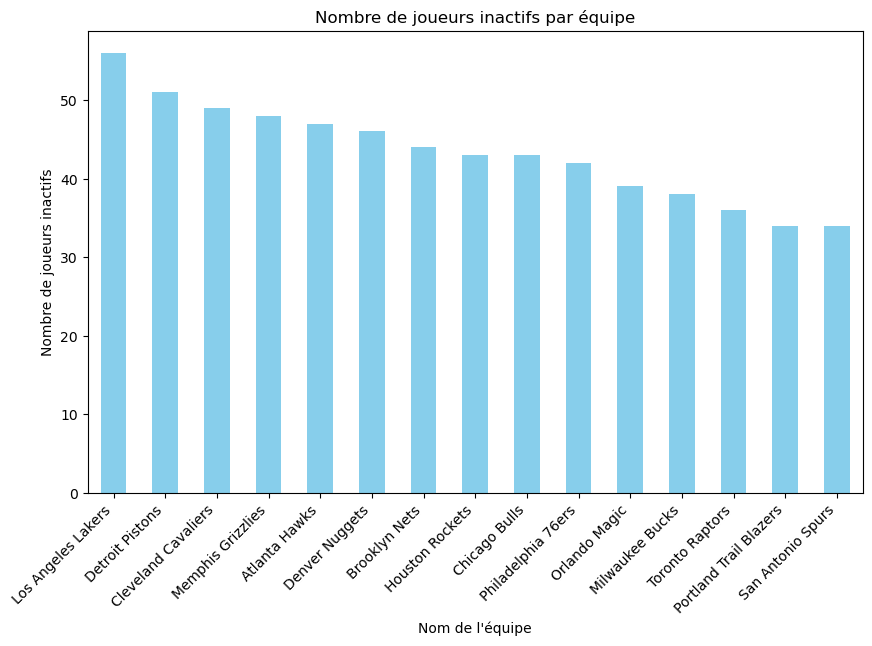

In [168]:

import matplotlib.pyplot as plt
%matplotlib inline

inactive_id = table['inactive_players']['player_id']
cpi = table['common_player_info']
inactive_team_ids = cpi[cpi['person_id'].isin(inactive_id) & cpi['team_id'] != 0]['team_id']
team_counts = inactive_team_ids.value_counts()
team_mapping = table['team'].set_index('id')['full_name']
team_counts.index = team_counts.index.map(team_mapping)
team_counts.plot(kind='bar', figsize=(10, 6), color='skyblue', title='Nombre de joueurs inactifs par équipe')
plt.xlabel('Nom de l\'équipe')
plt.ylabel('Nombre de joueurs inactifs')
plt.xticks(rotation=45, ha='right')  
plt.show()



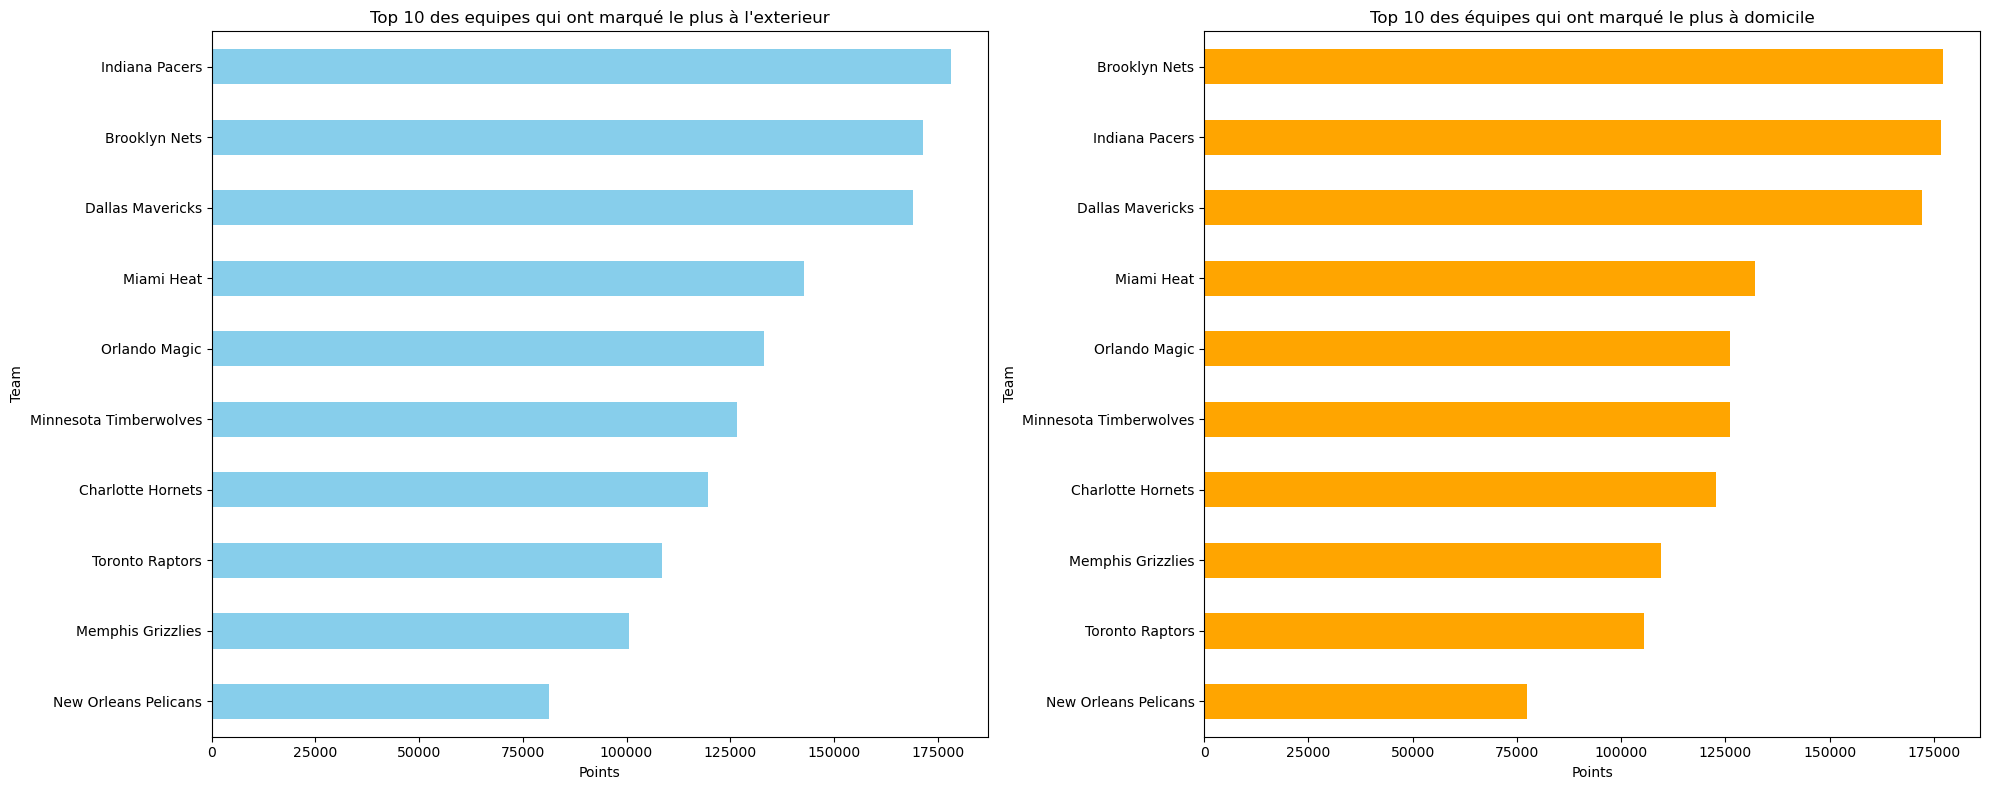

In [162]:
equipe_score_home = table['line_score'][['team_id_home', 'pts_home']].groupby("team_id_home").sum()
equipe_score_away = table['line_score'][['team_id_away', 'pts_away']].groupby("team_id_away").sum()

teams = table['team']
equipe_score_home = equipe_score_home.merge(teams, left_on="team_id_home", right_on="id")
equipe_score_away = equipe_score_away.merge(teams, left_on="team_id_away", right_on="id")

best_score_home = equipe_score_home.sort_values("pts_home", ascending=True).head(10)
best_score_away = equipe_score_away.sort_values("pts_away", ascending=True).head(10)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

best_score_away.plot(
    kind="barh",
    x="full_name",  
    y="pts_away",
    ax=ax[0],
    color="skyblue",
    legend=False
)
ax[0].set_title("Top 10 des equipes qui ont marqué le plus à l'exterieur")
ax[0].set_xlabel("Points")
ax[0].set_ylabel("Team")


best_score_home.plot(
    kind="barh",
    x="full_name",  
    y="pts_home",
    ax=ax[1],
    color="orange",
    legend=False
)
ax[1].set_title("Top 10 des équipes qui ont marqué le plus à domicile")
ax[1].set_xlabel("Points")
ax[1].set_ylabel("Team")

# Show the plot
plt.tight_layout()
plt.show()


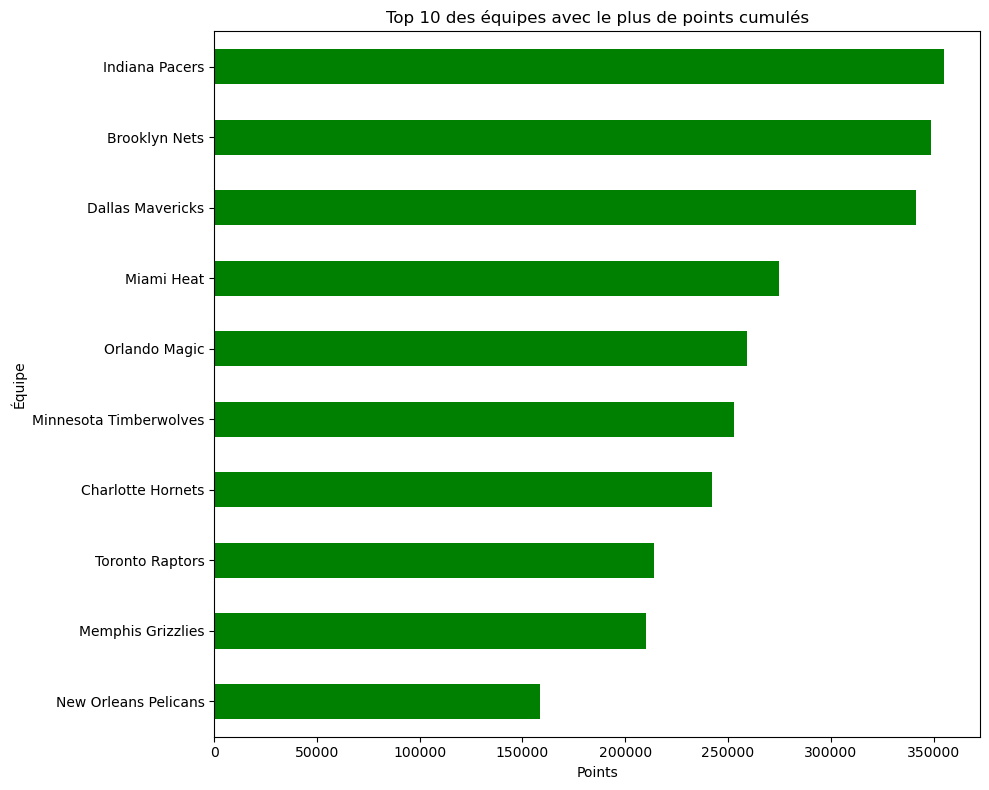

In [159]:
equipe_score_home = table['line_score'][['team_id_home', 'pts_home']].groupby("team_id_home").sum().reset_index()
equipe_score_away = table['line_score'][['team_id_away', 'pts_away']].groupby("team_id_away").sum().reset_index()

teams = table['team']
equipe_score_home = equipe_score_home.merge(teams, left_on="team_id_home", right_on="id")
equipe_score_away = equipe_score_away.merge(teams, left_on="team_id_away", right_on="id")

equipe_score_home = equipe_score_home.rename(columns={"pts_home": "pts", "team_id_home": "team_id"})
equipe_score_away = equipe_score_away.rename(columns={"pts_away": "pts", "team_id_away": "team_id"})

equipe_score_total = pd.concat([equipe_score_home[['team_id', 'pts', 'full_name']], 
                                 equipe_score_away[['team_id', 'pts', 'full_name']]])

equipe_score_total = equipe_score_total.groupby(["team_id", "full_name"]).sum().reset_index()

best_score_total = equipe_score_total.sort_values("pts", ascending=True).head(10)

fig, ax = plt.subplots(figsize=(10, 8))
best_score_total.plot(
    kind="barh",
    x="full_name",
    y="pts",
    ax=ax,
    color="green",
    legend=False
)
ax.set_title("Top 10 des équipes avec le plus de points cumulés")
ax.set_xlabel("Points")
ax.set_ylabel("Équipe")

plt.tight_layout()
plt.show()


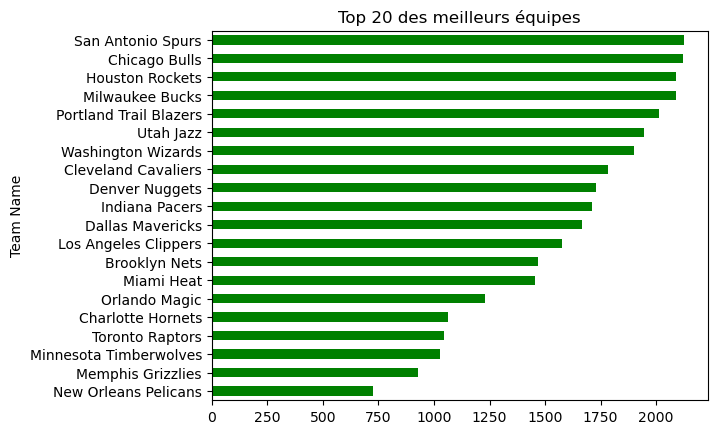

In [160]:
import numpy as np

table['line_score']['victor'] = np.where(
    table['line_score']['pts_home'] > table['line_score']['pts_away'],
    table['line_score']['team_id_home'],
    np.where(
        table['line_score']['pts_home'] < table['line_score']['pts_away'],
        table['line_score']['team_id_away'],
        None
    )
)

# print(table['line_score'][['game_id', 'team_id_home', 'pts_home', 'team_id_away', 'pts_away', 'victor']].head())

victor_counts = table["line_score"]["victor"].value_counts().reset_index()
victor_counts.columns = ['team_id', 'victories']

victor_counts_with_names = victor_counts.merge(
    table["team"],
    left_on='team_id',
    right_on='id',
    how='left'
)
victor_counts_with_names = victor_counts_with_names[['team_id', 'victories', 'full_name']]

# victor_counts_with_names.dropna(axis=1, subset="full_name")

victor_counts_with_names = victor_counts_with_names.dropna(subset="full_name").sort_values("victories").head(20)
victor_counts_with_names[['full_name', 'victories']].plot(
    kind="barh",
    x="full_name",
    y="victories",
    ylabel="Team Name",
    title="Top 20 des meilleurs équipes",
    color="green",
    legend=False
)
plt.show()

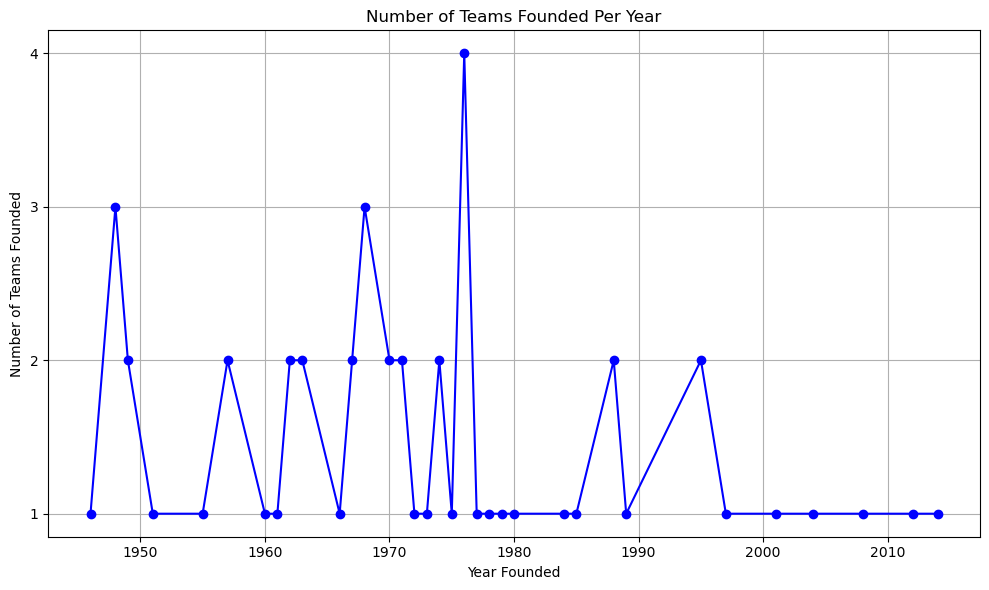

year_founded
1976    4
1968    3
1948    3
1988    2
1949    2
1963    2
1957    2
1971    2
1970    2
1967    2
1962    2
1974    2
1995    2
1946    1
1966    1
1951    1
1961    1
1955    1
1960    1
1975    1
1973    1
1972    1
1978    1
1979    1
1980    1
1984    1
1977    1
1985    1
1989    1
1997    1
2001    1
2004    1
2008    1
2012    1
2014    1
dtype: int64


In [175]:
teams_by_year = table['team_history'].groupby('year_founded').size()

teams_by_year.plot(kind="line", figsize=(10, 6), color="blue", marker="o")

plt.xlabel("Year Founded")
plt.ylabel("Number of Teams Founded")
plt.title("Number of Teams Founded Per Year")
plt.grid(True)

plt.yticks(np.arange(teams_by_year.min(), teams_by_year.max() + 1, 1))

plt.tight_layout()
plt.show()

# print(teams_by_year.sort_values(ascending=False))